# Off-Policy Learning on a Simple Seven-State MDP

This notebook explores a small Markov Decision Process that is often used to
demonstrate instability of standard temporal-difference methods under
off-policy training. The setting is based on Baird's counterexample.

The idea is to:
- Define a seven-state MDP with one "lower" state and six "upper" states.
- Represent states with feature vectors and learn a linear value function.
- Run semi-gradient off-policy TD(0) and track how the error behaves over time.
- Compute both RMSVE (Root Mean Squared Value Error) and RMSPBE (Root Mean Squared Projected Bellman Error).

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import os

# change working directory to the folder where your notebooks are
os.chdir("/Users/antonstepanyan/Desktop/RL/Reinforcement-Learning/counter-examples")  # <--- your real path here

# make sure the folder exists
os.makedirs("generated_images", exist_ok=True)

print("Current working directory:", os.getcwd())
print("Folders:", os.listdir())

# Reproducibility
rng = np.random.default_rng(0)

# -------------------------
#  MDP and feature setup
# -------------------------

states = np.arange(0, 7)
lower_state = 6

discount = 0.99
feature_vector_size = 8

features = np.zeros((len(states), feature_vector_size))

# Upper states: each has its own active feature plus a shared bias-like feature
for i in range(len(states) - 1):
    features[i, i] = 2.0
    features[i, feature_vector_size - 1] = 1.0

# Lower state: combination of the last two features
features[lower_state, feature_vector_size - 2] = 1.0
features[lower_state, feature_vector_size - 1] = 2.0

actions = {"dashed": 0, "solid": 1}

reward = 0.0

behavior_solid_probability = 1.0 / 7.0

state_distribution = np.ones(len(states)) / len(states)
state_distribution_matrix = np.diag(state_distribution)

projection_matrix = (
    features
    @ np.linalg.pinv(features.T @ state_distribution_matrix @ features)
    @ features.T
    @ state_distribution_matrix
)

interest = 1.0

def step(state, action):
    'Single transition of the MDP given a state and action.'
    if action == actions["solid"]:
        return lower_state
    # choose one of the upper states uniformly
    return rng.choice(states[:lower_state])

def target_policy(state):
    'Target policy: always takes the solid action.'
    return actions["solid"]

def behavior_policy(state):
    'Behavior policy: occasionally chooses the solid action, otherwise dashed.'
    if rng.binomial(n=1, p=behavior_solid_probability) == 1:
        return actions["solid"]
    return actions["dashed"]

def compute_RMSVE(weights):
    'Root Mean Squared Value Error under μ.'
    approx_values = features @ weights
    squared_errors = approx_values ** 2  # true values are zero in this example
    ms_ve = np.dot(squared_errors, state_distribution)
    return np.sqrt(ms_ve)

def compute_RMSPBE(weights):
    'Root Mean Squared Projected Bellman Error under μ.'
    bellman_errors = np.zeros(len(states))

    for s in states:
        for next_state in states:
            if next_state == lower_state:
                bellman_errors[s] += (
                    reward
                    + discount * np.dot(weights, features[next_state, :])
                    - np.dot(weights, features[s, :])
                )

    projected_be = projection_matrix @ bellman_errors
    squared_errors = projected_be ** 2
    ms_pbe = np.dot(squared_errors, state_distribution)
    return np.sqrt(ms_pbe)

def semi_gradient_off_policy_TD(state, weights, step_size):
    'One step of semi-gradient off-policy TD(0).'
    action = behavior_policy(state)
    next_state = step(state, action)

    if action == actions["dashed"]:
        rho = 0.0
    else:
        rho = 1.0 / behavior_solid_probability

    td_error = (
        reward
        + discount * np.dot(features[next_state, :], weights)
        - np.dot(features[state, :], weights)
    )

    weights += step_size * rho * td_error * features[state, :]
    return next_state, weights

Current working directory: /Users/antonstepanyan/Desktop/RL/Reinforcement-Learning/counter-examples
Folders: ['.DS_Store', 'generated_images', 'README.md', '.git', 'notebooks', '.idea', 'src']


## Semi-gradient Off-Policy TD(0) Experiment

In this section we run semi-gradient TD(0) using data generated by the
behavior policy while still evaluating the target policy. We track how the
error evolves as learning progresses.

In [15]:
num_steps = 50_000
step_size = 0.05

# Start in one of the upper states
current_state = 0

# Initialize weights to zero
w = np.zeros(feature_vector_size)

rmsve_history = []
rmspbe_history = []

for t in range(num_steps):
    current_state, w = semi_gradient_off_policy_TD(current_state, w, step_size)

    if (t + 1) % 100 == 0:
        rmsve_history.append(compute_RMSVE(w))
        rmspbe_history.append(compute_RMSPBE(w))

print("Final RMSVE:", rmsve_history[-1])
print("Final RMSPBE:", rmspbe_history[-1])

Final RMSVE: 0.0
Final RMSPBE: 0.0


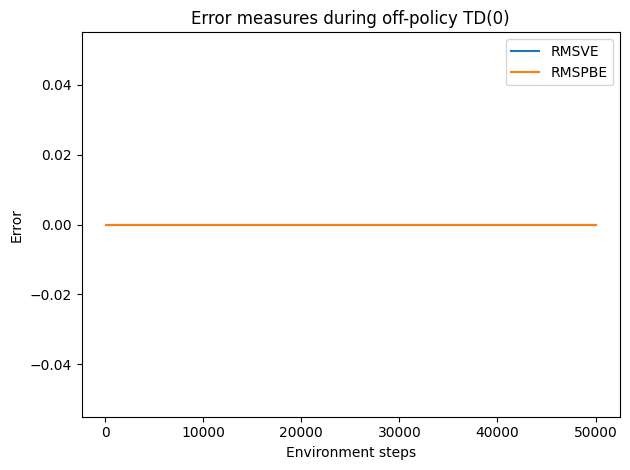

In [17]:
iters = np.arange(100, num_steps + 1, 100)

plt.figure()
plt.plot(iters, rmsve_history, label="RMSVE")
plt.plot(iters, rmspbe_history, label="RMSPBE")
plt.xlabel("Environment steps")
plt.ylabel("Error")
plt.legend()
plt.title("Error measures during off-policy TD(0)")
plt.tight_layout()
plt.savefig("generated_images/baird_plot_1.png", dpi=300, bbox_inches='tight')
plt.show()



### Discussion

In this seven-state example, semi-gradient off-policy TD(0) can behave
poorly, especially for certain step-size settings. The purpose of this
notebook is to highlight how the error measures evolve and motivate the
need for more robust gradient-based TD methods and emphatic approaches.